## Os Dados

Este projeto de Machine Learning será focado no processamento de linguagem natural! 
Utilizaremos um Dataset obtido do Twitter com 100K postagens entre os dias 01/08/2018 e 20/10/2018. Cada postagem é classificada como **positiva**, **negativa** ou **neutra**.  

Descrição das colunas:

- **id**: ID único para o tweet  
- **tweet_text**: Texto da publicação no Twitter  
- **tweet_date**: Data da publicação no Twitter  
- **sentiment**: 0, se negativo; 1, se positivo; 2, se neutro  
- **query_used**: Filtro utilizado para buscar a publicação

## O Problema

O objetivo é desenvolver um modelo para detectar o sentimento de uma publicação do Twitter a classificando em uma das três categorias: **positiva**, **negativa** ou **neutra**. O texto da publicação está disponível na coluna "tweet_text". 

# Desenvolvimento do projeto

In [ ]:
# importando dataset train
import pandas as pd

df_twitter = pd.read_csv('/content/Dados/train/Train3Classes.csv')

print(df_twitter.shape)

df_twitter.sample(10).head()

(95000, 5)


,id,tweet_text,tweet_date,sentiment,query_used
83990,1032357104923893760,#trabalho NBC CTO 4/2018: Aprova o Comunicado ...,Wed Aug 22 20:01:28 +0000 2018,2,#trabalho
35436,1032001571977142272,@fluvialacerda em entrevista para canal do #yo...,Tue Aug 21 20:28:43 +0000 2018,2,#noticia
89537,1047314444869672960,"@leticiasampaio Hey, se precisar desabafar tam...",Wed Oct 03 02:36:36 +0000 2018,1,:)
60570,1049298349520773122,eu amo tanto a patroa :(,Mon Oct 08 13:59:56 +0000 2018,0,:(
63037,1046996533965705217,@Soldado_DoRei @leiaftsolo Olha ele tentando o...,Tue Oct 02 05:33:20 +0000 2018,0,:(


In [ ]:
# dividindo o dataset em treino e test
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_twitter, test_size = 0.2, random_state=10)

print(df_train.shape)

print(df_test.shape)

(76000, 5)
(19000, 5)


### **Analise**

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76000 entries, 53574 to 83209
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          76000 non-null  int64 
 1   tweet_text  76000 non-null  object
 2   tweet_date  76000 non-null  object
 3   sentiment   76000 non-null  int64 
 4   query_used  76000 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.5+ MB


In [ ]:
# verificando dados nulos 
df_train.isnull().sum()

id            0
tweet_text    0
tweet_date    0
sentiment     0
query_used    0
dtype: int64

In [ ]:
# verificando dados duplicados
df_train.duplicated().value_counts()

False    76000
dtype: int64

Este dataset nao possui dados nulos e duplicados

In [ ]:
# verificando o balanceamento do dataset
df_train['sentiment'].value_counts(normalize = True)

0    0.335066
1    0.333237
2    0.331697
Name: sentiment, dtype: float64

In [ ]:
# verificando quantos anos tem na data
data_ano = df_train['tweet_date'].apply(lambda x: x[-4:])
data_ano.value_counts()

2018    76000
Name: tweet_date, dtype: int64

In [ ]:
# verificando os meses da data
data_mes = df_train['tweet_date'].apply(lambda x: x[4:7])
data_mes.value_counts()

Oct    46221
Sep    26315
Aug     3464
Name: tweet_date, dtype: int64

Os dados são de 2018 com dados de 3 meses (Agosto, Setembro e Outubro). Maior parte dos dados sendo de Outubro. É ano de eleições e justo meses de campanha, votação (outubro) e pós copa do Mundo. Deve haver muitas palavras voltadas para estes temas. Veremos depois no wordcloud.

### Hashtag

Contando os valores em 'query used' (hashtag) e verificando quantidade de hashtags que ja estão no texto para ver se é necessario acrescentar no texto como formar de melhorar o modelo

In [ ]:
# resetando o indice para realizar analises posteriores
df_train.reset_index(drop = True, inplace = True)

In [ ]:
# contando quantas vezes aparece o query used dentro do texto em tweet_text
query =  list(df_train['query_used'][x] in df_train['tweet_text'][x] for x in range (len(df_train['tweet_text'])))
print('Valor False:',query.count(False))
print('Valor True:',query.count(True))

Valor False: 24917
Valor True: 51083


In [ ]:
# contando valores em query used
df_train.groupby('query_used')['sentiment'].value_counts().sort_values(ascending = False)

query_used     sentiment
:(             0            25465
:)             1            25326
folha          2             4034
estadao        2             3082
#fato          2             2772
g1             2             2758
exame          2             2735
#trabalho      2             2387
#oportunidade  2             1966
jornaloglobo   2             1858
veja           2             1691
#noticia       2              880
#novidade      2              735
#curiosidade   2              311
Name: sentiment, dtype: int64

In [ ]:
# a hashtag :( simboliza algue triste, vamos verificar se confere com o sentimento negativo
df_train.loc[(df_train['query_used'] == ':('), 'sentiment'].value_counts()

0    25465
Name: sentiment, dtype: int64

In [ ]:
# verificando o mesmo com o simbolo :)
df_train.loc[(df_train['query_used'] == ':)'), 'sentiment'].value_counts()

1    25326
Name: sentiment, dtype: int64

In [ ]:
df_train.groupby('query_used')['sentiment'].value_counts()

query_used     sentiment
#curiosidade   2              311
#fato          2             2772
#noticia       2              880
#novidade      2              735
#oportunidade  2             1966
#trabalho      2             2387
:(             0            25465
:)             1            25326
estadao        2             3082
exame          2             2735
folha          2             4034
g1             2             2758
jornaloglobo   2             1858
veja           2             1691
Name: sentiment, dtype: int64

Esta análise mostra a relaçao do query_used com o sentimento (resposta),  tendo sentido juntar o texto + hastag. Mas, vamos realizar isto mais a frente, juntando tambem o periodo do tweet, que analisaremos logo mais.

### Funções

In [ ]:
# criando a função do plot wordcloud
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(texts):
    plt.figure(figsize=(10, 10))
    text = ' '.join(texts.tolist())
    WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
    words = WC.generate(text)
    plt.imshow(words, interpolation='bilinear')
    plt.show()

In [ ]:
!pip install unidecode

from bs4 import BeautifulSoup
import re
import nltk
nltk.download('stopwords')
from nltk.stem import RSLPStemmer
nltk.download('rslp')
from unidecode import unidecode


# funçao para limpar o texto retirando url, codigos html e stopwords
def clean_html(text):
    
    
    clean_text = str(text)
    # retirando url do texto 
    clean_text = re.sub("https*\S+", " ", clean_text.lower())
    
        # retirando códigos html
    clean_text = BeautifulSoup(clean_text, 'html5lib').text
    
    # retirando stopwords e acrescentando mais palavras a esta lista
    stop_words = nltk.corpus.stopwords.words('portuguese')
    stop_words.extend(['pra', 'q', 'p', 'd', 'o'])
    
    # filtro com função lambda que retorna as palavras que não são stopwords
    # usado split para verificar a palavra inteira e não as letras de cada palavra
    clean_text = ' '.join(list(filter(lambda x: x not in stop_words, clean_text.split())))     
    
    

      # retorna o texto sem url, html e stopwords
    return clean_text

     |████████████████████████████████| 235 kB 8.1 MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


In [ ]:
# criando uma função para que as horas fiquem arredondas sempre para baixo em nova coluna

def arredonda_horas(horario):

  # fazendo list comprehension de tamanho 24 para criar lista com as 24 horas no formato hh:mm:ss
  horas = [f'{x:0>2}:00:00' for x in range (0,24)]

  # converte o valor de entrada em string e dividi para ficar no formato hh:mm:ss
  horario = str(horario).split()

  # usando o loop para comparar os dois primeiros valores da variavel de entrada (horario) 
  # com os dois primeiros valores de cada elemento da lista horas
  # e assim fazendo a transformação
  for x in horario:
    for y in horas:
      
      if x[0:2] == y[0:2]:
            horario = y

  return horario

In [ ]:
# criando uma coluna com as horas retiradas de tweet_date

def separa_hora (df):

  from datetime import datetime
  
  
  df['horario'] = df['tweet_date'].apply(lambda x: datetime.strptime(x[11:19], '%H:%M:%S').time())
  print(df.head())
  
  df['hora'] = df['horario'].apply(arredonda_horas)

  

  return df

In [ ]:
# função para retornar o periodo da hora
def periodo(horario):
  horario = str(horario)
  if '06:00:00' <= horario <=  '11:59:59': return 'Manha'
  elif '12:00:00' <= horario <= '17:59:59': return 'Tarde'
  elif '18:00:00' <= horario <= '23:59:59': return 'Noite'
  elif '00:00:00' <= horario <= '05:59:59': return 'Madrugada'
  

In [ ]:
# função para printar as métricas

def printar_metricas(train, y_train, y_train_pred, valid, y_valid, y_valid_pred):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    #O modelo de classificação é multiclasse, então foi colocado 'average = micro' para o precision e recall, 
    # ja que o dados estão balanceados 

    acc_train = accuracy_score(y_train, y_train_pred)
    prec_train = precision_score(y_train, y_train_pred, average = 'micro')
    rec_train = recall_score(y_train, y_train_pred, average = 'micro')
    f1_train = f1_score(y_train, y_train_pred, average='micro')


    acc_valid = accuracy_score(y_valid, y_valid_pred)
    prec_valid = precision_score(y_valid, y_valid_pred, average = 'micro')
    rec_valid = recall_score(y_valid, y_valid_pred, average = 'micro')
    f1_valid = f1_score(y_valid, y_valid_pred, average='micro')


    print(f'{train}:\nF1: {f1_train:.2f}, Acc: {acc_train:.2f}, Precision: {prec_train:.2f}, Recall: {rec_train:.2f}')
    print(f'{valid}:\nF1: {f1_valid:.2f},Acc: {acc_valid:.2f}, Precision: {prec_valid:.2f}, Recall: {rec_valid:.2f}')

In [ ]:
# função para plotar a matriz de confusão
def matriz_conf(y, y_pred):
    from mlxtend.plotting import plot_confusion_matrix
    from sklearn.metrics import confusion_matrix
    from matplotlib import pyplot as plt

    cm = confusion_matrix(y, y_pred)
    plt.rcParams["figure.figsize"] = [5,5]
    
    plot_confusion_matrix(conf_mat=cm)
    plt.show()

### Texto

In [ ]:
# contando caracteres e palavras
df_train['count_caracteres'] = df_train['tweet_text'].str.len()
df_train['count_palavras'] = df_train['tweet_text'].str.split().str.len()

In [ ]:
print('Caracteres:',df_train['count_caracteres'].sum())
print('Palavras',df_train['count_palavras'].sum())

Caracteres: 7371452
Palavras 1137152


In [ ]:

df_train[['count_caracteres', 'count_palavras']].describe(percentiles=[.1, .2, .3, .4, .5, .75, .9, .99]).T

,count,mean,std,min,10%,20%,30%,40%,50%,75%,90%,99%,max
count_caracteres,76000.0,96.992789,62.532496,7.0,32.0,43.0,55.0,71.0,86.0,124.0,187.0,293.0,686.0
count_palavras,76000.0,14.962526,9.960064,1.0,5.0,7.0,9.0,11.0,13.0,18.0,29.0,49.0,77.0


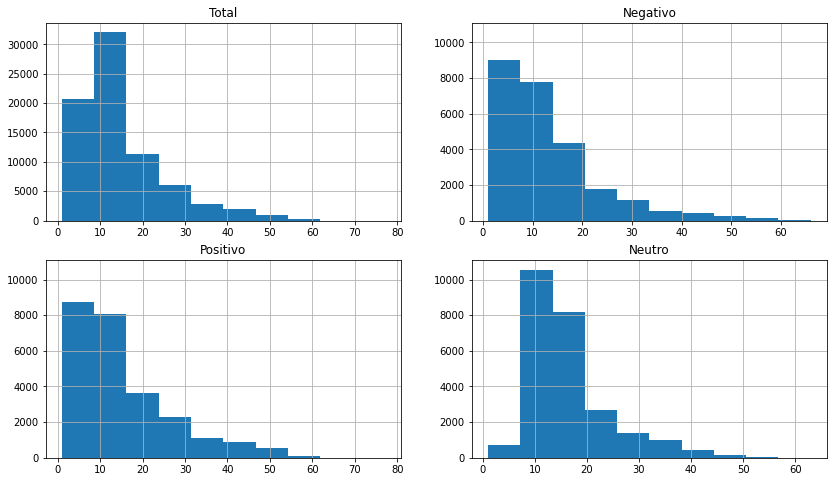

In [ ]:
# plotando a relação de sentimentos com contagem de caracteres e palavras
from matplotlib import pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(14, 8))
max_y = 0

ax1 = fig.add_subplot(221)
df_train['count_palavras'].hist()
plt.title('Total')


ax2 = fig.add_subplot(222)
df_train.loc[(df_train['sentiment'] == 0), 'count_palavras'].hist()
plt.title('Negativo')
_, max_y_f = ax2.get_ylim()
max_y = max_y_f if max_y_f > max_y else max_y

ax3 = fig.add_subplot(223)
df_train.loc[(df_train['sentiment'] == 1), 'count_palavras'].hist()
plt.title('Positivo')
_, max_y_f = ax3.get_ylim()
max_y = max_y_f if max_y_f > max_y else max_y


ax4=fig.add_subplot(224)
df_train.loc[(df_train['sentiment'] == 2), 'count_palavras'].hist()
plt.title('Neutro')
_, max_y_f = ax4.get_ylim()
max_y = max_y_f if max_y_f > max_y else max_y


ax2.set(ylim=(0, max_y))
ax3.set(ylim=(0, max_y))
ax4.set(ylim=(0, max_y))

plt.show()

Texto com poucas palavras tende a ser positivo ou negativo. Em torno de 10 palavras a tendencia é maior para neutro. A partir de 20 palavras a distribuição é bem parecida.

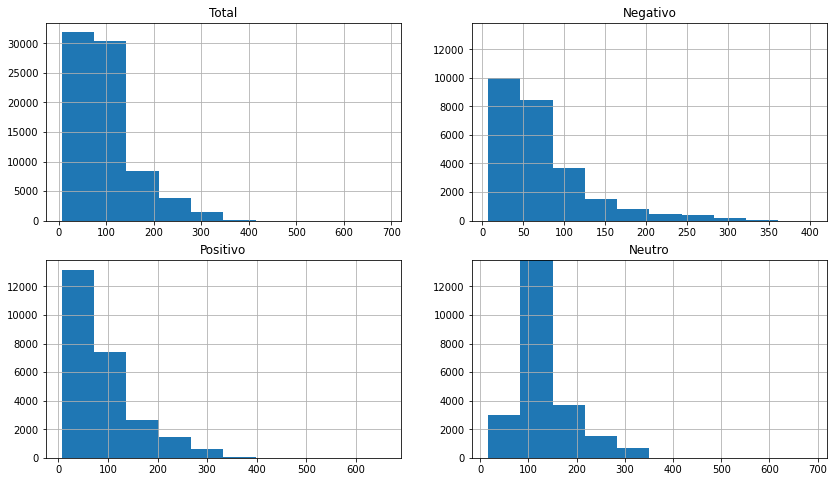

In [ ]:
fig = plt.figure(figsize=(14, 8))

max_y = 0

ax1 = fig.add_subplot(221)
df_train['count_caracteres'].hist()
plt.title('Total')

ax2 = fig.add_subplot(222)
df_train.loc[(df_train['sentiment'] == 0), 'count_caracteres'].hist()
plt.title('Negativo')
_, max_y_f = ax2.get_ylim()
max_y = max_y_f if max_y_f > max_y else max_y


ax3 = fig.add_subplot(223)
df_train.loc[(df_train['sentiment'] == 1), 'count_caracteres'].hist()
plt.title('Positivo')
_, max_y_f = ax3.get_ylim()
max_y = max_y_f if max_y_f > max_y else max_y

ax4=fig.add_subplot(224)
df_train.loc[(df_train['sentiment'] == 2), 'count_caracteres'].hist()
plt.title('Neutro')
_, max_y_f = ax3.get_ylim()
max_y = max_y_f if max_y_f > max_y else max_y

ax2.set(ylim=(0, max_y))
ax3.set(ylim=(0, max_y))
ax4.set(ylim=(0, max_y))

plt.show()

Os sentimentos negativos e positivos tem tendencia de poucos caracteres (assim como as palavras).  Com mais caracteres tende para neutro(em torno de 100). Depois disto as distribuições fica parecidas.

**Vamos verificar as palavras que mais aparecem no texto e nos sentimentos**

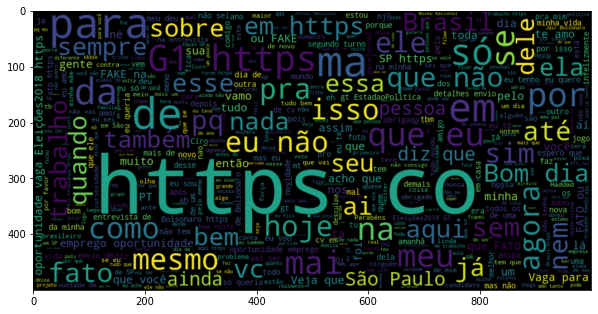

In [ ]:
# usando a função para plotar a nuvem de palavras
plot_wordcloud(df_train['tweet_text'])

:Os texto possuem palavras pequenas (stopwords) e url. Vamos tratar para melhorar a análise com a função criada 'clean_html' 

In [ ]:
# aplicando a função aos textos
df_train['tweet_text'] = df_train['tweet_text'].apply(clean_html)

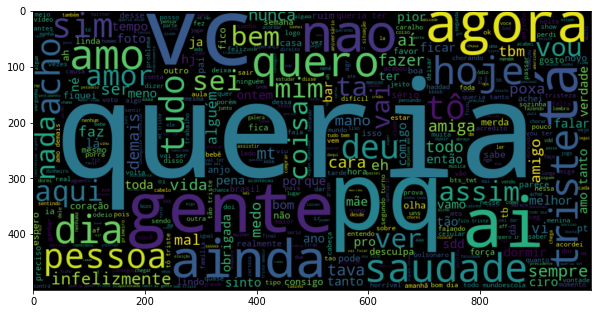

In [ ]:
# wordcloud dos sentimentos negativos
plot_wordcloud(df_train.loc[df_train['sentiment'] == 0, 'tweet_text'])

Palavras negativas: triste, infelizmente, queria (verbo no preterito, conotação negativa), poxa,saudade. Não teve palavras relacionadas com futebol, copa do mundo nem eleições.

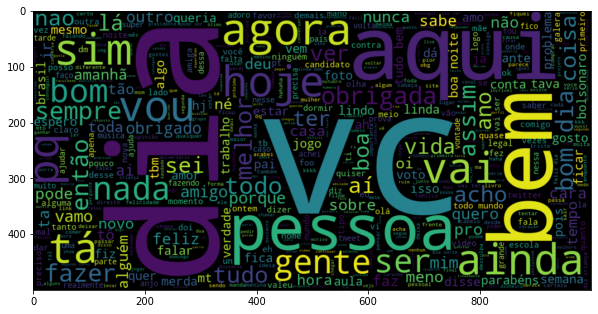

In [ ]:
plot_wordcloud(df_train.loc[df_train['sentiment'] == 1, 'tweet_text'])

palavras positivas: bem, bom, sim, dia. Também sem palavras voltadas para copa do mundo e eleições

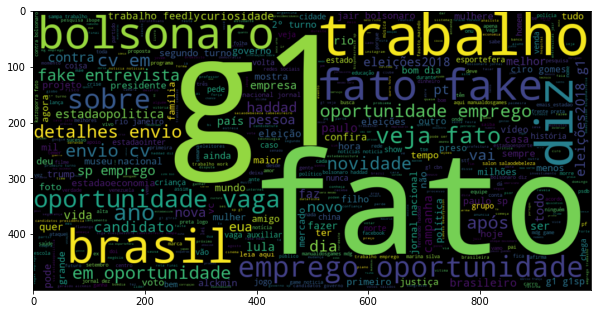

In [ ]:
plot_wordcloud(df_train.loc[df_train['sentiment'] == 2, 'tweet_text'])

palavras neutras: fato, brasil,eleições (e palavras relacionadas: politica, bolsonaro, lula, estadao, g1, eua, campanha), trabalho (e palavras relacionadas: emprego, oportunidade, vaga. No modelo com embedings vamos verificar se estas palavras estarão proximas). Aqui aparecem as palavras relacionadas a eleições devido ao ano e meses dos dados, nada relacionado a copa. E estão conforme as hashtags (query used,) apontando para esses temas e midias informativas (g1, folha, estadao...). Tambem não aparece pronomes, difere bem das negativas e postivas.

### Data

Vamos iniciar aplicando as funções criadas para tratar as horas e criar novas colunas

In [ ]:
# aplicando a função ao dataset
separa_hora(df_train)

                    id  ...   horario
0  1044965829304098816  ...  15:04:02
1  1049153207006584832  ...  04:23:11
2  1047452192104271875  ...  11:43:57
3  1046786830513963009  ...  15:40:03
4  1045417410608713728  ...  20:58:28

[5 rows x 8 columns]


,id,tweet_text,tweet_date,sentiment,query_used,count_caracteres,count_palavras,horario,hora
0,1044965829304098816,cientistas sp testam células-tronco tratar inc...,Wed Sep 26 15:04:02 +0000 2018,2,folha,97,10,15:04:02,15:00:00
1,1049153207006584832,@kimjongdawee jess :( ta sendo mt decepcionant...,Mon Oct 08 04:23:11 +0000 2018,0,:(,114,20,04:23:11,04:00:00
2,1047452192104271875,"@luana_andrads ""olha aqui, ilustríssimo michel...",Wed Oct 03 11:43:57 +0000 2018,1,:),111,19,11:43:57,11:00:00
3,1046786830513963009,"@carolinedsff dinda bela vista alagou tbbb, me...",Mon Oct 01 15:40:03 +0000 2018,0,:(,81,16,15:40:03,15:00:00
4,1045417410608713728,"@rara_oficial @windowsbr poxa cara, bacana, vo...",Thu Sep 27 20:58:28 +0000 2018,1,:),164,26,20:58:28,20:00:00
...,...,...,...,...,...,...,...,...,...
75995,1045432624553103361,"mano, tô morrendo aqui, tô febre, dor cabeça g...",Thu Sep 27 21:58:55 +0000 2018,1,:),125,24,21:58:55,21:00:00
75996,1035753041587302401,manchetes americanas 31 agosto: donald trump a...,Sat Sep 01 04:55:43 +0000 2018,2,#noticia,133,14,04:55:43,04:00:00
75997,1046945568705196033,ai fico triste :(((((((((((,Tue Oct 02 02:10:49 +0000 2018,0,:(,60,7,02:10:49,02:00:00
75998,1039296471558971392,"gasolina diesel caros postos, diz anp",Mon Sep 10 23:36:02 +0000 2018,2,folha,81,12,23:36:02,23:00:00


In [ ]:
# conferindo se as colunas criandas foram toda preenchida
df_train['horario'].isnull().sum()

0

In [ ]:
df_train['hora'].isnull().sum()

0

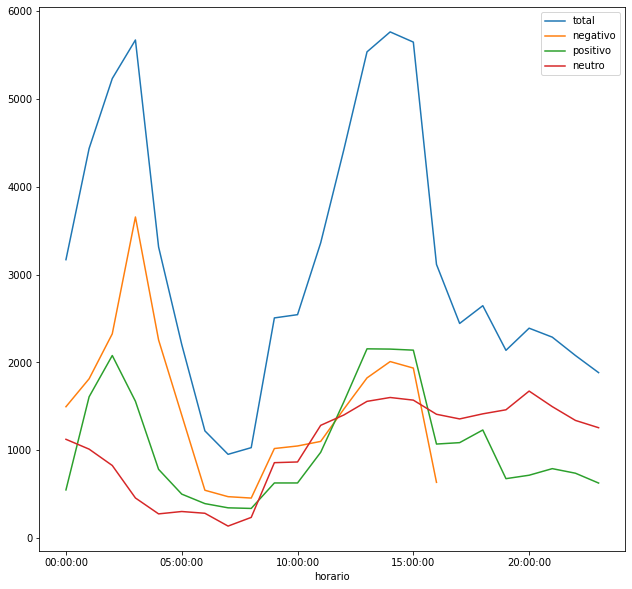

In [ ]:
# plotando os tweets conforme horario e sentimento

# criando um df somente com horario e contagem de tweets
hora_tweets = pd.DataFrame(df_train['hora'].value_counts())
hora_tweets.rename_axis(index= 'horario', inplace = True)
hora_tweets.columns = ['total']
hora_tweets.sort_values(by = 'horario', inplace = True)

plt.rcParams["figure.figsize"] = [10.5,10]

# plotando as horas totais (hora_tweets) e os sentimentos
hora_tweets.plot();
df_train.loc[df_train['sentiment'] == 0, 'hora'].value_counts().sort_index().plot(label = 'negativo')
df_train.loc[df_train['sentiment'] == 1, 'hora'].value_counts().sort_index().plot(label = 'positivo')
df_train.loc[df_train['sentiment'] == 2, 'hora'].value_counts().sort_index().plot(label = 'neutro')

plt.legend();



Percebe-se os picos no periodo da madrugada crescendo da meia noite até um pouco antes das 5h. E outra crescente em torno de 10h e 15h quando começa a cair novamente. Ou seja, nota-se um periodo maior de tweet por volta do horario do almoço, e periodo da alta madrugada, o que pode-se pensar é que 'tuitam' nos horarios livres. Nota-se os tweets neutros em uma crescente começando pela manhã, diferente dos outros que tem picos e depoios caem bastante.

Colocaremos outra coluna com os periodos para mais analises, atraves da função periodo

In [ ]:
# aplicando a função no horario do tweet 

df_train['periodo'] = df_train['horario'].apply(periodo)
df_train['periodo'].head()

0        Tarde
1    Madrugada
2        Manha
3        Tarde
4        Noite
Name: periodo, dtype: object

In [ ]:
# verificando se há alguma coluna nao preenchida com o retorno da função
df_train['periodo'].isnull().sum()

0

In [ ]:
df_train['periodo'].value_counts(normalize = True)

Tarde        0.354329
Madrugada    0.316158
Noite        0.176645
Manha        0.152868
Name: periodo, dtype: float64

Bem mais que da metade dos tweets são realizados a tarde e de madrugada, conforme vimos anteriormente

In [ ]:
df_train.loc[df_train['sentiment'] ==0, 'periodo'].value_counts(normalize = True)

Madrugada    0.508463
Tarde        0.309209
Manha        0.182329
Name: periodo, dtype: float64

Se observa que de madrugada, onde há um grande pico de tweets, a tendencia é sentimento negativo

In [ ]:
df_train.loc[df_train['sentiment'] ==1, 'periodo'].value_counts(normalize = True)

Tarde        0.401050
Madrugada    0.279515
Noite        0.188778
Manha        0.130656
Name: periodo, dtype: float64

In [ ]:
df_train.loc[df_train['sentiment'] ==2, 'periodo'].value_counts(normalize = True)

Tarde        0.352969
Noite        0.342893
Madrugada    0.158713
Manha        0.145424
Name: periodo, dtype: float64

O que se percebe que no 1 periodo de pico, madrugada, a sua maioria é sentimento negativo, e no 2 periodo de pico, à tarde, os sentimentos positivos e neutros se dividem.

Outra conclusão interessante desta analise pelo horario é que parece haver uma transição dos sentimentos, como o humor das pessoas durante o dia: na madrugada e manhã os sentimentos são negativos, se tornando mais positivos a tarde e terminando neutro a noite. É um dataset pequeno para generalizar de tal forma, mas é interessante como estes dados podem orientar decisões de empresas.

### Criando o Modelo

In [ ]:
# dividindo o data set em treino e validação
df_training, df_valid = train_test_split(df_train, test_size=0.1, random_state = 10)

x_train, y_train = df_training['tweet_text'], df_training['sentiment']
x_valid, y_valid = df_valid['tweet_text'], df_valid['sentiment']

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(68400,) (68400,)
(7600,) (7600,)


### Aplicando Bag of Words

In [ ]:
# Aplicando o BagOfWords
from sklearn.feature_extraction.text import CountVectorizer

# foi colocado o max_feature de 5.000, no computador pessoal e colab não foi possivel realizar 
# um GridSearch com 10.000, memória insuficiente
vectorizer = CountVectorizer(max_features=5000)

vectorizer.fit(x_train)

CountVectorizer(max_features=5000)

In [ ]:
x_train_transformed = vectorizer.transform(x_train).toarray()

print(x_train_transformed.shape)

x_valid_transformed = vectorizer.transform(x_valid).toarray()

print(x_valid_transformed.shape)

(68400, 5000)
(7600, 5000)


###  Modelo Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# aplicando GridSearch com o score f1 micro para multiclasses
modelo = RandomForestClassifier()

parameters = {
    'max_depth': [ 3, 5, 10],
    'n_estimators': [100, 500,1000],
    'criterion': ['entropy', 'gini'],
    }

clf = GridSearchCV(modelo, parameters, verbose=3, scoring='f1_micro', cv= 3)

clf.fit(x_train_transformed, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END criterion=entropy, max_depth=3, n_estimators=100;, score=0.659 total time=  24.7s
[CV 2/3] END criterion=entropy, max_depth=3, n_estimators=100;, score=0.663 total time=  20.7s
[CV 3/3] END criterion=entropy, max_depth=3, n_estimators=100;, score=0.671 total time=  20.5s
[CV 1/3] END criterion=entropy, max_depth=3, n_estimators=500;, score=0.681 total time= 1.6min
[CV 2/3] END criterion=entropy, max_depth=3, n_estimators=500;, score=0.686 total time= 1.6min
[CV 3/3] END criterion=entropy, max_depth=3, n_estimators=500;, score=0.686 total time= 1.6min
[CV 1/3] END criterion=entropy, max_depth=3, n_estimators=1000;, score=0.683 total time= 3.5min
[CV 2/3] END criterion=entropy, max_depth=3, n_estimators=1000;, score=0.692 total time= 3.7min
[CV 3/3] END criterion=entropy, max_depth=3, n_estimators=1000;, score=0.680 total time= 3.7min
[CV 1/3] END criterion=entropy, max_depth=5, n_estimators=100;, score=0.661 total

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [100, 500, 1000]},
             scoring='f1_micro', verbose=3)

In [ ]:
clf.best_params_

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 500}

In [ ]:
modelo = RandomForestClassifier(max_depth = 10, n_estimators = 500, random_state = 12)

In [ ]:
modelo.fit(x_train_transformed, y_train)

RandomForestClassifier(max_depth=10, n_estimators=500, random_state=12)

In [ ]:
y_train_pred = modelo.predict(x_train_transformed)

y_valid_pred = modelo.predict(x_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(68400,) (7600,)


In [ ]:
printar_metricas('Treino',y_train, y_train_pred, 'Validação',y_valid, y_valid_pred)

Treino:
F1: 0.70, Acc: 0.70, Precision: 0.70, Recall: 0.70
Validação:
F1: 0.69,Acc: 0.69, Precision: 0.69, Recall: 0.69


O modelo não apresenta overfiting. Este é o modelo que servirá como base, o objetivo é melhorar a métrica de 70%


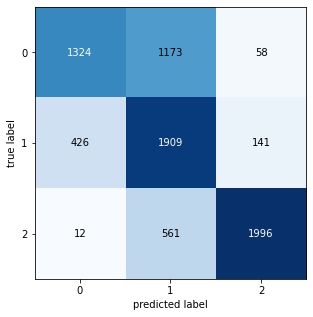

In [ ]:

matriz_conf(y_valid, y_valid_pred)

Este modelo erra muito quando preve positivo mas é negativo(1173), vamos verificar se o modelo com o Naive Bayes melhora a métrica e também este erro.

### Modelo Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
modelo = MultinomialNB()

modelo

MultinomialNB()

In [ ]:
# Treino do modelo Naive bayes
modelo.fit(x_train_transformed, y_train)

MultinomialNB()

In [ ]:
y_train_pred = modelo.predict(x_train_transformed)

y_valid_pred = modelo.predict(x_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(68400,) (7600,)


In [ ]:
printar_metricas('Treino',y_train, y_train_pred, 'Validação',y_valid, y_valid_pred)

Treino:
F1: 0.80, Acc: 0.80, Precision: 0.80, Recall: 0.80
Validação:
F1: 0.78,Acc: 0.78, Precision: 0.78, Recall: 0.78


Com o Naive Bayes o modelo melhorou 10%, o melhor modelo até então.

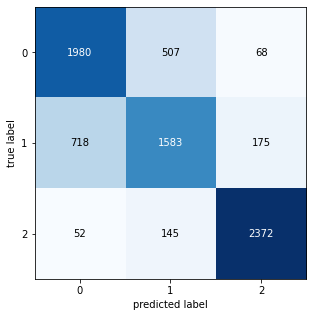

In [ ]:
matriz_conf(y_valid, y_valid_pred)

Este modelo melhorou a metrica e diminiu bem o erro falso positivo citado no modelo anterior.

### LightGBM

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
modelo = LGBMClassifier( n_estimators=2500, max_depth=4, learning_rate=0.05, random_state=12)

modelo

LGBMClassifier(learning_rate=0.05, max_depth=4, n_estimators=2500,
               random_state=12)

In [ ]:
modelo.fit(x_train_transformed, y_train)

LGBMClassifier(learning_rate=0.05, max_depth=4, n_estimators=2500,
               random_state=12)

In [ ]:
y_train_pred = modelo.predict(x_train_transformed)

y_valid_pred = modelo.predict(x_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(68400,) (7600,)


In [ ]:
printar_metricas('Treino',y_train, y_train_pred, 'Validação',y_valid, y_valid_pred)

Treino:
F1: 0.80, Acc: 0.80, Precision: 0.80, Recall: 0.80
Validação:
F1: 0.78,Acc: 0.78, Precision: 0.78, Recall: 0.78


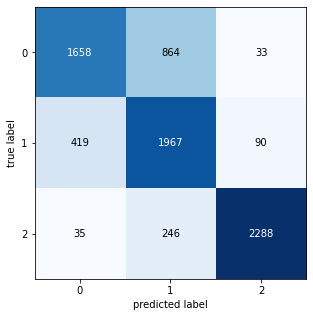

In [ ]:
matriz_conf(y_valid, y_valid_pred)

**Trabalhando-se manualmente os hiperparametros conseguimos chegar na performance do Naive Bayes, a mudança ocorre que este teve menos falsos negativos.**

Vamos verificar como os modelos performam com a feature joined ainda no Bag of Words

### **Features: Texto + hashtag + periodo**

In [ ]:
def join_features_1 (df):

  df['joined'] = df['tweet_text'] + ' ' + df['query_used'] + ' '+ df['periodo']

  return df

In [ ]:
join_features_1(df_train)


,id,tweet_text,tweet_date,sentiment,query_used,count_caracteres,count_palavras,horario,hora,periodo,joined
0,1044965829304098816,cientistas sp testam células-tronco tratar inc...,Wed Sep 26 15:04:02 +0000 2018,2,folha,97,10,15:04:02,15:00:00,Tarde,cientistas sp testam células-tronco tratar inc...
1,1049153207006584832,@kimjongdawee jess :( ta sendo mt decepcionant...,Mon Oct 08 04:23:11 +0000 2018,0,:(,114,20,04:23:11,04:00:00,Madrugada,@kimjongdawee jess :( ta sendo mt decepcionant...
2,1047452192104271875,"@luana_andrads ""olha aqui, ilustríssimo michel...",Wed Oct 03 11:43:57 +0000 2018,1,:),111,19,11:43:57,11:00:00,Manha,"@luana_andrads ""olha aqui, ilustríssimo michel..."
3,1046786830513963009,"@carolinedsff dinda bela vista alagou tbbb, me...",Mon Oct 01 15:40:03 +0000 2018,0,:(,81,16,15:40:03,15:00:00,Tarde,"@carolinedsff dinda bela vista alagou tbbb, me..."
4,1045417410608713728,"@rara_oficial @windowsbr poxa cara, bacana, vo...",Thu Sep 27 20:58:28 +0000 2018,1,:),164,26,20:58:28,20:00:00,Noite,"@rara_oficial @windowsbr poxa cara, bacana, vo..."
...,...,...,...,...,...,...,...,...,...,...,...
75995,1045432624553103361,"mano, tô morrendo aqui, tô febre, dor cabeça g...",Thu Sep 27 21:58:55 +0000 2018,1,:),125,24,21:58:55,21:00:00,Noite,"mano, tô morrendo aqui, tô febre, dor cabeça g..."
75996,1035753041587302401,manchetes americanas 31 agosto: donald trump a...,Sat Sep 01 04:55:43 +0000 2018,2,#noticia,133,14,04:55:43,04:00:00,Madrugada,manchetes americanas 31 agosto: donald trump a...
75997,1046945568705196033,ai fico triste :(((((((((((,Tue Oct 02 02:10:49 +0000 2018,0,:(,60,7,02:10:49,02:00:00,Madrugada,ai fico triste :((((((((((( :( Madrugada
75998,1039296471558971392,"gasolina diesel caros postos, diz anp",Mon Sep 10 23:36:02 +0000 2018,2,folha,81,12,23:36:02,23:00:00,Noite,"gasolina diesel caros postos, diz anp folha Noite"


In [ ]:
# verificando se houve linhas não preenchidas

df_train['joined'].isnull().sum()

0

In [ ]:
df_training, df_valid = train_test_split(df_train, test_size=0.1, random_state = 10)

x_train, y_train = df_training['joined'], df_training['sentiment']
x_valid, y_valid = df_valid['joined'], df_valid['sentiment']

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(68400,) (68400,)
(7600,) (7600,)


In [ ]:
vectorizer = CountVectorizer(max_features=5000)

vectorizer.fit(x_train)

CountVectorizer(max_features=5000)

In [ ]:
x_train_transformed = vectorizer.transform(x_train).toarray()

print(x_train_transformed.shape)

x_valid_transformed = vectorizer.transform(x_valid).toarray()

print(x_valid_transformed.shape)

(68400, 5000)
(7600, 5000)


In [ ]:
modelo = MultinomialNB()

modelo

MultinomialNB()

In [ ]:
modelo.fit(x_train_transformed, y_train)

MultinomialNB()

In [ ]:
y_train_pred = modelo.predict(x_train_transformed)

y_valid_pred = modelo.predict(x_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(68400,) (7600,)


In [ ]:
printar_metricas('Treino',y_train, y_train_pred, 'Validação',y_valid, y_valid_pred)

Treino:
F1: 0.84, Acc: 0.84, Precision: 0.84, Recall: 0.84
Validação:
F1: 0.83,Acc: 0.83, Precision: 0.83, Recall: 0.83


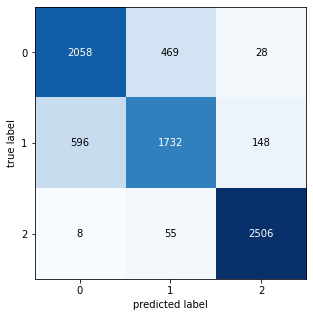

In [ ]:
plt.rcParams["figure.figsize"] = [5,5]
matriz_conf(y_valid, y_valid_pred)

Com esta feature o modelo Naive Bayes melhorou, vamos testar com o LightGBM

In [ ]:
modelo = LGBMClassifier( n_estimators=2500, max_depth=4, learning_rate=0.05, random_state=12)

modelo

LGBMClassifier(learning_rate=0.05, max_depth=4, n_estimators=2500,
               random_state=12)

In [ ]:
modelo.fit(x_train_transformed, y_train)

LGBMClassifier(learning_rate=0.05, max_depth=4, n_estimators=2500,
               random_state=12)

In [ ]:
y_train_pred = modelo.predict(x_train_transformed)

y_valid_pred = modelo.predict(x_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(68400,) (7600,)


In [ ]:
printar_metricas('Treino',y_train, y_train_pred, 'Validação',y_valid, y_valid_pred)

Treino:
F1: 0.86, Acc: 0.86, Precision: 0.86, Recall: 0.86
Validação:
F1: 0.84,Acc: 0.84, Precision: 0.84, Recall: 0.84


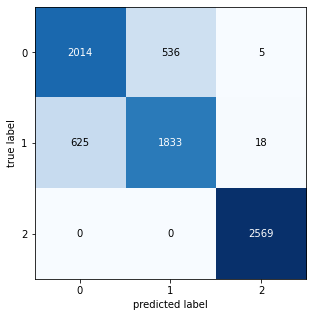

In [ ]:
matriz_conf(y_valid, y_valid_pred)

**O LightGBM performou ainda melhor que o Naive Bayes. A partir de agora, esta será a feature de entrada. Vamos verificar a 'tonenização' com o TF-IDF**

### TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)

vectorizer.fit(x_train)

TfidfVectorizer(max_features=5000)

In [ ]:
x_train_transformed = vectorizer.transform(x_train).toarray()

print(x_train_transformed.shape)

x_valid_transformed = vectorizer.transform(x_valid).toarray()

print(x_valid_transformed.shape)

(68400, 5000)
(7600, 5000)


In [ ]:
modelo = MultinomialNB()

In [ ]:
modelo.fit(x_train_transformed, y_train)

MultinomialNB()

In [ ]:
y_train_pred = modelo.predict(x_train_transformed)

y_valid_pred = modelo.predict(x_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(68400,) (7600,)


In [ ]:
printar_metricas('Treino',y_train, y_train_pred, 'Validação',y_valid, y_valid_pred)

Treino:
F1: 0.84, Acc: 0.84, Precision: 0.84, Recall: 0.84
Validação:
F1: 0.82,Acc: 0.82, Precision: 0.82, Recall: 0.82


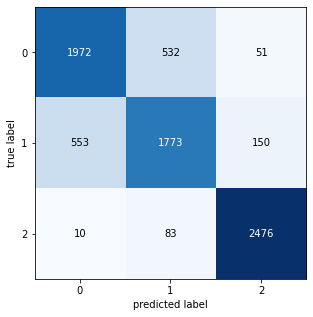

In [ ]:
matriz_conf(y_valid, y_valid_pred)

**TF-IDF com o LightGBM**

In [ ]:
modelo = LGBMClassifier(n_estimators=2500, max_depth=3, learning_rate=0.05, random_state=12)

modelo

LGBMClassifier(learning_rate=0.05, max_depth=3, n_estimators=2500,
               random_state=12)

In [ ]:
modelo.fit(x_train_transformed, y_train)

LGBMClassifier(learning_rate=0.05, max_depth=3, n_estimators=2500,
               random_state=12)

In [ ]:
y_train_pred = modelo.predict(x_train_transformed)

y_valid_pred = modelo.predict(x_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(68400,) (7600,)


In [ ]:
printar_metricas('Treino',y_train, y_train_pred, 'Validação',y_valid, y_valid_pred)

Treino:
F1: 0.86, Acc: 0.86, Precision: 0.86, Recall: 0.86
Validação:
F1: 0.84,Acc: 0.84, Precision: 0.84, Recall: 0.84


**Obs. Os hiperparametros do LightGBM foram os mesmos pois estes que obtiveram melhor performance sem overfiting**

**Como o modelo com TF-IDF e LightGBM performou semelhante ao Bag of Words, o melhor modelo até então seria (BoW) por ser mais simples**

### Embedding 

In [ ]:

from gensim.models import Word2Vec

In [ ]:

def tokenize(text):
    from gensim.utils import simple_preprocess
    
    return simple_preprocess(text, min_len=1)

In [ ]:


model_w2v = Word2Vec(
        sentences=x_train.apply(
            lambda x: tokenize(x)
        ),
         size=300,
         window=5,
         min_count=1,
         workers=4
    )

In [ ]:
len(model_w2v.wv.vocab)

74609

In [ ]:
model_w2v.wv.most_similar('manhã', topn=5)

[('saio', 0.9881023168563843),
 ('atrasada', 0.9870052337646484),
 ('escola', 0.9823656678199768),
 ('chego', 0.9809513092041016),
 ('att', 0.9805766344070435)]

As variaveis do periodo aparecem como similar

In [ ]:
model_w2v.wv.most_similar('folha', topn=5)

[('jornaloglobo', 0.9760580658912659),
 ('exame', 0.9680062532424927),
 ('estadao', 0.9666247963905334),
 ('pólio', 0.9651734828948975),
 ('reitor', 0.9637291431427002)]

Palavras observadas como neutro no wordcloud aparecem como similar, principalmente midias informativas

In [ ]:
model_w2v.wv.most_similar('saudade', topn=5)

[('chorando', 0.993069052696228),
 ('chorei', 0.9913042187690735),
 ('morrendo', 0.991244912147522),
 ('desanimada', 0.9900473952293396),
 ('gostando', 0.9886929392814636)]

In [ ]:
model_w2v.wv.most_similar('bem', topn=5)

[('acontecendo', 0.97402024269104),
 ('espero', 0.973609447479248),
 ('aí', 0.9692256450653076),
 ('legal', 0.9681429862976074),
 ('td', 0.9618648886680603)]

In [ ]:
from tqdm import tqdm
import numpy as np


def to_word_vector(words, w2v):

    vectors = []

    for word in words:
        vectors.append(w2v.wv[word] if word in w2v.wv.vocab else np.zeros(w2v.vector_size))

    return np.mean(vectors, axis=0)

def embeddings(x, w2v):
    x = x.copy()

    x = x.apply(tokenize)

    x = np.vstack([[to_word_vector(sentences, w2v)] for sentences in tqdm(x)])

    return x

In [ ]:
x_train_transformed = embeddings(x_train, model_w2v)

x_valid_transformed = embeddings(x_valid, model_w2v)

100%|██████████| 7600/7600 [00:00<00:00, 19197.71it/s]


In [ ]:
x_train_transformed.shape, x_valid_transformed.shape

((68400, 300), (7600, 300))

In [ ]:
x_train_transformed

array([[ 0.10394481, -0.01263051, -0.1312738 , ..., -0.3334235 ,
        -0.44380638,  0.3361149 ],
       [ 0.09309915, -0.11295976, -0.1012864 , ..., -0.13054946,
        -0.1853466 ,  0.19287205],
       [ 0.14459102, -0.07308197, -0.13742125, ..., -0.328718  ,
        -0.3818308 ,  0.3732554 ],
       ...,
       [ 0.11086967, -0.07161079, -0.13530134, ..., -0.23355061,
        -0.303718  ,  0.23394166],
       [-0.1610198 , -0.03547641, -0.27715814, ..., -0.25586122,
        -0.13274565, -0.08132912],
       [ 0.06196077, -0.06325144, -0.13121006, ..., -0.11609397,
        -0.230994  ,  0.1289897 ]], dtype=float32)

In [ ]:
modelo = LGBMClassifier(n_estimators=1000, max_depth=3, learning_rate=0.05, random_state=12)

modelo

LGBMClassifier(learning_rate=0.05, max_depth=3, n_estimators=1000,
               random_state=12)

In [ ]:
modelo.fit(x_train_transformed, y_train)

LGBMClassifier(learning_rate=0.05, max_depth=3, n_estimators=1000,
               random_state=12)

In [ ]:
y_train_pred = modelo.predict(x_train_transformed)

y_valid_pred = modelo.predict(x_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(68400,) (7600,)


In [ ]:
printar_metricas('Treino',y_train, y_train_pred, 'Validação',y_valid, y_valid_pred)

Treino:
F1: 0.86, Acc: 0.86, Precision: 0.86, Recall: 0.86
Validação:
F1: 0.84,Acc: 0.84, Precision: 0.84, Recall: 0.84


Este teve o f1 score semelhante ao melhor modelo (Bag of Words com o LightGBM), então considera-se o Bow por ser mais simples. Mas, antes de terminar, e fazer a predição do teste e o subm, vamos testar adicionando o horario do texto nesta feature e verificar se há melhora no BoW.

### Features: texto + hashtag + periodo + hora

In [ ]:
df_train['joined 2'] = df_train['joined'] + ' ' + df_train['hora']

In [ ]:
df_train['joined 2'][0]

'cientistas sp testam células-tronco tratar incontinência urinária folha Tarde 15:00:00'

In [ ]:
df_training, df_valid = train_test_split(df_train, test_size=0.1, random_state = 10)

x_train, y_train = df_training['joined 2'], df_training['sentiment']
x_valid, y_valid = df_valid['joined 2'], df_valid['sentiment']

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(68400,) (68400,)
(7600,) (7600,)


In [ ]:
vectorizer.fit(x_train)

CountVectorizer(max_features=5000)

In [ ]:
x_train_transformed = vectorizer.transform(x_train).toarray()

print(x_train_transformed.shape)

x_valid_transformed = vectorizer.transform(x_valid).toarray()

print(x_valid_transformed.shape)

(68400, 5000)
(7600, 5000)


In [ ]:

modelo = MultinomialNB()
modelo

MultinomialNB()

In [ ]:
modelo.fit(x_train_transformed, y_train)

MultinomialNB()

In [ ]:
y_train_pred = modelo.predict(x_train_transformed)

y_valid_pred = modelo.predict(x_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(68400,) (7600,)


In [ ]:
printar_metricas('Treino',y_train, y_train_pred, 'Validação',y_valid, y_valid_pred)

Treino:
F1: 0.84, Acc: 0.84, Precision: 0.84, Recall: 0.84
Validação:
F1: 0.83,Acc: 0.83, Precision: 0.83, Recall: 0.83


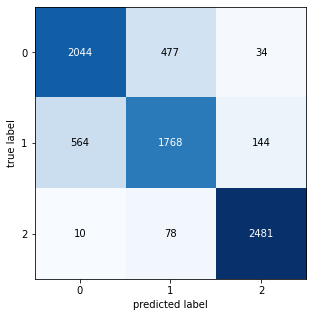

In [ ]:
matriz_conf(y_valid, y_valid_pred)

Com inclusão do horario o Naive Bayes mantece as metricas, uma diferença aqui é que diminuiu um pouco dos falsos positivos e leve aumento nos falsos negativos.
Vamos verificar com o LightGBM que anteriormente performou melhor

In [ ]:
modelo = LGBMClassifier( n_estimators=3000, max_depth=4, learning_rate=0.05, random_state=12)

modelo

LGBMClassifier(learning_rate=0.05, max_depth=4, n_estimators=3000,
               random_state=12)

In [ ]:
modelo.fit(x_train_transformed, y_train)

LGBMClassifier(learning_rate=0.05, max_depth=4, n_estimators=3000,
               random_state=12)

In [ ]:
y_train_pred = modelo.predict(x_train_transformed)

y_valid_pred = modelo.predict(x_valid_transformed)

print(y_train_pred.shape, y_valid_pred.shape)

(68400,) (7600,)


In [ ]:
printar_metricas('Treino',y_train, y_train_pred, 'Validação',y_valid, y_valid_pred)

Treino:
F1: 0.87, Acc: 0.87, Precision: 0.87, Recall: 0.87
Validação:
F1: 0.85,Acc: 0.85, Precision: 0.85, Recall: 0.85


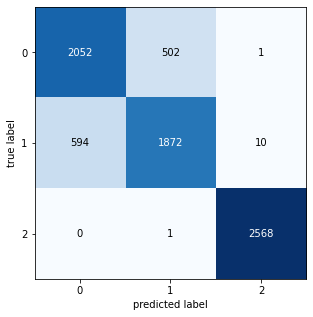

In [ ]:
matriz_conf(y_valid, y_valid_pred)

Este é o modelo a ser implementado com melhor performance

### Teste

Vamos alterar a função que juntam as colunas para acrescentar o horario

In [ ]:
def join_features (df):

  df['joined'] = df['tweet_text'] + ' ' + df['query_used'] + ' '+ df['periodo'] + ' ' + df['hora']

  return df

In [ ]:
# função para tratar todo o dataset

def tratamento(df):
  
  # tratando a coluna texto
  df['tweet_text'] = df['tweet_text'].apply(clean_html)
  
  # tratando o horarios
  separa_hora(df)
  df['periodo'] = df['horario'].apply(periodo)
  
  # juntando as features para o modelo
  join_features(df)

  return df

In [ ]:
tratamento(df_test)

In [ ]:
x_test, y_test = df_test['joined'], df_test['sentiment']

print(x_test.shape, y_test.shape)


(19000,) (19000,)


In [ ]:
# utilizando vetores do Bag of words
x_test_transformed = vectorizer.transform(x_test).toarray()

In [ ]:
modelo

LGBMClassifier(learning_rate=0.05, max_depth=4, n_estimators=3000,
               random_state=12)

In [ ]:
y_test_pred = modelo.predict(x_test_transformed)

print(y_test_pred.shape)

(19000,)


In [ ]:
printar_metricas('Treino',y_train, y_train_pred, 'Teste',y_test, y_test_pred)

Treino:
F1: 0.87, Acc: 0.87, Precision: 0.87, Recall: 0.87
Teste:
F1: 0.85,Acc: 0.85, Precision: 0.85, Recall: 0.85


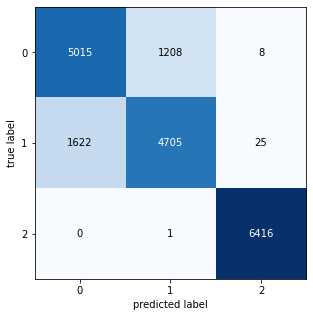

In [ ]:
matriz_conf(y_test, y_test_pred)

**Performance do Teste: 85%**

## Conclusão

Uma das primeiras coisas que observei neste estudo, é como o Naive Bayes, mesmo sendo simples tem muito boa performance em situações deste tipo. Para o LightGBM se equiparar e ultrapassar em pouco as metricas, foi necessário muito tempo ajustando e verificando os hiperparâmetros.

O Bag of words mesmo sendo mais simples, se equiparou ao TF-IDF, por isso foi escolhido. Talvez com mais experiência com o Embedding e, principalmente utilizando o Keras, este supere o BoW.

Se o intuito fosse alem dos sentimentos o Embedding seria bem aproveitavel, pois teve-se a mesma performance.

Acredito que o modelo escolhido identifica com boa acertividade os sentimentos destas publicações. Mas, penso não se adequar a outras situações/contextos, pois, conforme as análises, pela data dos dados, havia tendência dos dados para eleições, politica  e mídias que foram tratadas como neutras. As hashtags (query_used) traz um viés no final limitando o modelo a ter melhor performance em um dataset semelhante, por isso não se adequar para outros contextos. Talvez com uso de vetores pre-treinados (gensim.downloader) seria melhor, mas a implementação para estes em portugues, pelo que pesquisei estava sendo diferente, então, acabei nao realizando.

Este projeto foi interessante para se trabalhar a feature, que no final foi uma junção de mais de uma coluna e tratamentos, levando mais dados para o modelo e trazendo melhoras nas métricas
